<a href="https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics of Behavior Tutorial II - Part 3

In this session, we will focus on how to uncover long timescale properties of complex dynamical systems through a transfer operator approach.

Before we start, load the following python packages:

In [1]:
# Environment setup
!pip install -q -r https://raw.githubusercontent.com/AntonioCCosta/DPG_PhysicsBehavior_2026/main/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 3.7 MB/s eta 0:00:00


In [2]:

import os

if not os.path.exists("DPG_PhysicsBehavior_2026"):
    !git clone https://github.com/AntonioCCosta/DPG_PhysicsBehavior_2026.git
else:
    %cd DPG_PhysicsBehavior_2026
    !git pull
    %cd ..

import sys, platform
print("Python:", sys.version)
print("Platform:", platform.platform())

Cloning into 'DPG_PhysicsBehavior_2026'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 95 (delta 39), reused 24 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (95/95), 16.08 MiB | 17.01 MiB/s, done.
Resolving deltas: 100% (39/39), done.
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.113+-x86_64-with-glibc2.35


In [3]:
import h5py
import numpy as np
import numpy.ma as ma
sys.path.append('./DPG_PhysicsBehavior_2026/utils')
import operator_calculations as op_calc
import delay_embedding as embed
import partition_methods as cl
import coarse_graining as cgm
import matplotlib.pyplot as plt

# Extending to a (slightly) more complex system

for which the longest timescales are not immediate obvious. To do that, we will now move onto a chaotic dynamical system, and see how these ideas generalize beyond the equilibrium example shown above.

Take the Lorenz equations, a canonical example of the transition to chaos in three dimensional nonlinear dynamics:

$$
\begin{cases}
\dot{x} = \sigma (y - x), \\
\dot{y} = x(\rho - z) - y, \\
\dot{z} = xy - \beta z.
\end{cases}
$$

with $\rho=28$, $\sigma=10$ and $\beta = 8/3$. In this regime, the dynamics is chaotic, and the system relaxes to the iconic butterfly attractor. Let's check a simulations.

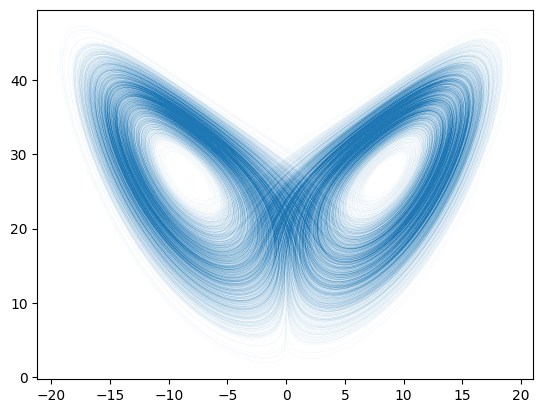

In [58]:
from scipy.integrate import odeint

def Lorenz(state,t,sigma,rho,beta):
    # unpack the state vector
    x,y,z = state
    # compute state derivatives
    xd = sigma * (y-x)
    yd = (rho-z)*x - y
    zd = x*y - beta*z
    # return the state derivatives
    return [xd, yd, zd]

dt = 0.02
frameRate=1/dt
T = 5000
discard_T = 500
T_total = T+discard_T
state0 = np.array([-8, -8, 27])
t = np.linspace(0, T_total, int(T_total*frameRate))
sigma,rho,beta=10,28,8/3
tseries=np.array(odeint(Lorenz,state0,t,args=(sigma,rho,beta)),dtype=np.float64)[int(discard_T/dt):]
plt.plot(tseries[:,0],tseries[:,2],lw=.02)
plt.show()

Unlike the overdamped Langevin dynamics in a double well, where the long-term dynamics are dictated by the gradient of a potential landscape, here is it less obvious to determine what the slow modes of the dynamics are. In addition, while for the 1d example above we could directly obtain a finite difference approximation of the Fokker-Planck operator, here we need to derive directly from the time series observations.

We will do that using the Ulam-Galerkin method, as in notebook_2.

In [156]:
N=1000
#labels_all is an array with the partition that each point in the time series belongs to
#centers is the centroid of each k-means cluster
labels_all,centers = cl.kmeans_partition(tseries,N,batchsize=10000,return_centers=True)

In [168]:
delay=1
P_emp = op_calc.transition_matrix(labels_all,delay)
eigvals_emp,eigvecs_emp = op_calc.sorted_spectrum(P_emp,k=5)
eigvecs_emp = eigvecs_emp.real
eigvecs_emp = eigvecs_emp/np.linalg.norm(eigvecs_emp,axis=0)
phi2_emp = eigvecs_emp[:,1]

In [160]:
phi2_traj = phi2_emp[labels_all]

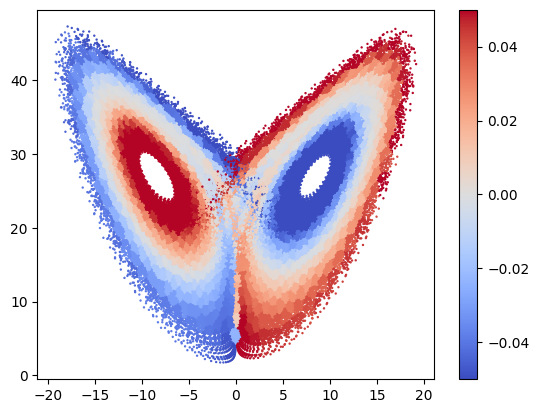

In [167]:
color_abs = np.max(np.abs(phi2_emp))
plt.scatter(tseries[:,0],tseries[:,2],c=phi2_traj,cmap='coolwarm',s=0.5,vmin=-.05,vmax=.05)
plt.colorbar()
plt.show()

So it seems like the slowest mode for the Lorenz attractor identifies almost invariant sets that connect the outer part of one lobe to the inner part of another. This means that those transitions are more likely that transitioning to the center part of the same lobe, for example. You can play around with some simulations to see that.

It turns out that this separatrix actually follows a higher order fixed point, an unstable periodic orbit, for which $\vec{x}(t+T) \sim \vec{x}(t)$. While the system does not directly visit the unstable periodic orbit (UPO), we can find it's location by searching for its shadows: trajectories that nearly return to the same point after a time T. We will focus on the shortest UPO, using (Barrio et al. Comput. Phys. Commun. 2015) as a reference.

In [200]:
from scipy.signal import find_peaks

eps = .3
windows = []
wsizes = []
for t_idx in np.random.randint(0,len(tseries)-1000,100000):
    dist = 1/(np.linalg.norm(tseries[t_idx+1:t_idx+500]-tseries[t_idx],axis=1)**2)
    peaks, _ = find_peaks(dist, height=1/(eps**2))
    if len(peaks)>2:
        wsizes.append(peaks)
        windows.append([[t_idx,t_idx+peaks[k]] for k in range(len(peaks))])



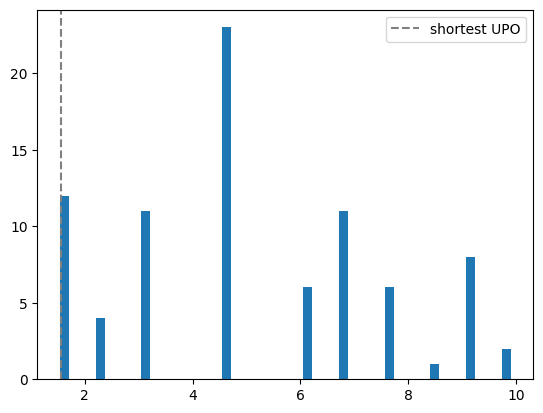

In [202]:
T_UPO_ref = 1.5586522107161747275678702092126960705284
plt.hist(np.hstack(wsizes)*dt,bins=50)
# plt.xlim(0,5)
plt.axvline(T_UPO_ref,c='gray',ls='--',label='shortest UPO')
plt.legend()
plt.show()

In [203]:
t0,tf = np.vstack(windows)[np.argmin(np.hstack(wsizes))]
print((tf-t0)*dt)

1.54


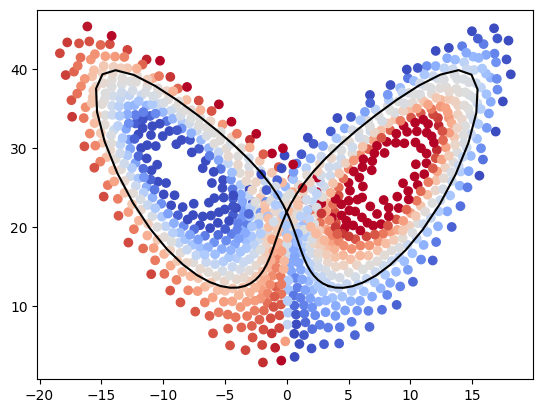

In [204]:
plt.plot(tseries[t0:tf+2,0],tseries[t0:tf+2,2],c='k')
plt.scatter(centers[:,0],centers[:,2],c=phi2_emp,cmap='coolwarm',vmax=0.05,vmin=-0.05)

plt.show()

As you can see, we find an analogous to the metastable states of equilibrium systems but here for a dissipative chaotic system for which the slow modes are aligned to transitions across a complex higher order fixed point.